<a href="https://colab.research.google.com/github/AdityaMVerma/Traffic_Sign_Recogntion/blob/main/Traffic_Sign_Recognition_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload kaggle.json (browse your system to select it)
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syb65adityaverma","key":"ec5468a1be6c94e869e7d92a21495425"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Make a directory for Kaggle and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions to avoid permission errors
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip the dataset
!unzip gtsrb-german-traffic-sign.zip -d ./gtsrb


Archive:  gtsrb-german-traffic-sign.zip
replace ./gtsrb/Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**This notebook builds a traffic sign recognition model using the German Traffic Sign dataset. The dataset contains images of various traffic signs, and the goal is to classify these signs based on their images.**

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from skimage.io import imread
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import itertools
from tensorflow.keras.utils import to_categorical
from PIL import Image

## **2. Loading and Inspecting the Train Data**

In [ ]:
df = pd.read_csv('./gtsrb/Train.csv')
df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [ ]:
# Add the full path to each image file
df['Path'] = './gtsrb/' + df['Path']

In [ ]:
# Get information about the dataset such as columns, data types, and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [ ]:
# Inspect the dataset for missing values
df.isnull().sum()

,0
Width,0
Height,0
Roi.X1,0
Roi.Y1,0
Roi.X2,0
Roi.Y2,0
ClassId,0
Path,0


In [ ]:
# Inspect the dataset for duplicates
df.duplicated().sum()

0

In [ ]:
# Check the average width of the images
df['Width'].mean()

50.83587951745773

In [ ]:
# Check the average height of the images
df['Height'].mean()

50.328929582493814

## **3. Loading and Inspecting the Test Data**

In [ ]:
test_data = pd.read_csv('./gtsrb/Test.csv')
test_data

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [ ]:
# Add the full path to each image file
test_data['Path'] = './gtsrb/' + test_data['Path']

In [ ]:
# Get information about the dataset such as columns, data types, and missing values
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null  object
dtypes: int64(7), object(1)
memory usage: 789.5+ KB


In [ ]:
# Inspect the dataset for missing values
test_data.isnull().sum()

,0
Width,0
Height,0
Roi.X1,0
Roi.Y1,0
Roi.X2,0
Roi.Y2,0
ClassId,0
Path,0


## **4. Visualizing a Random Subset of Images**

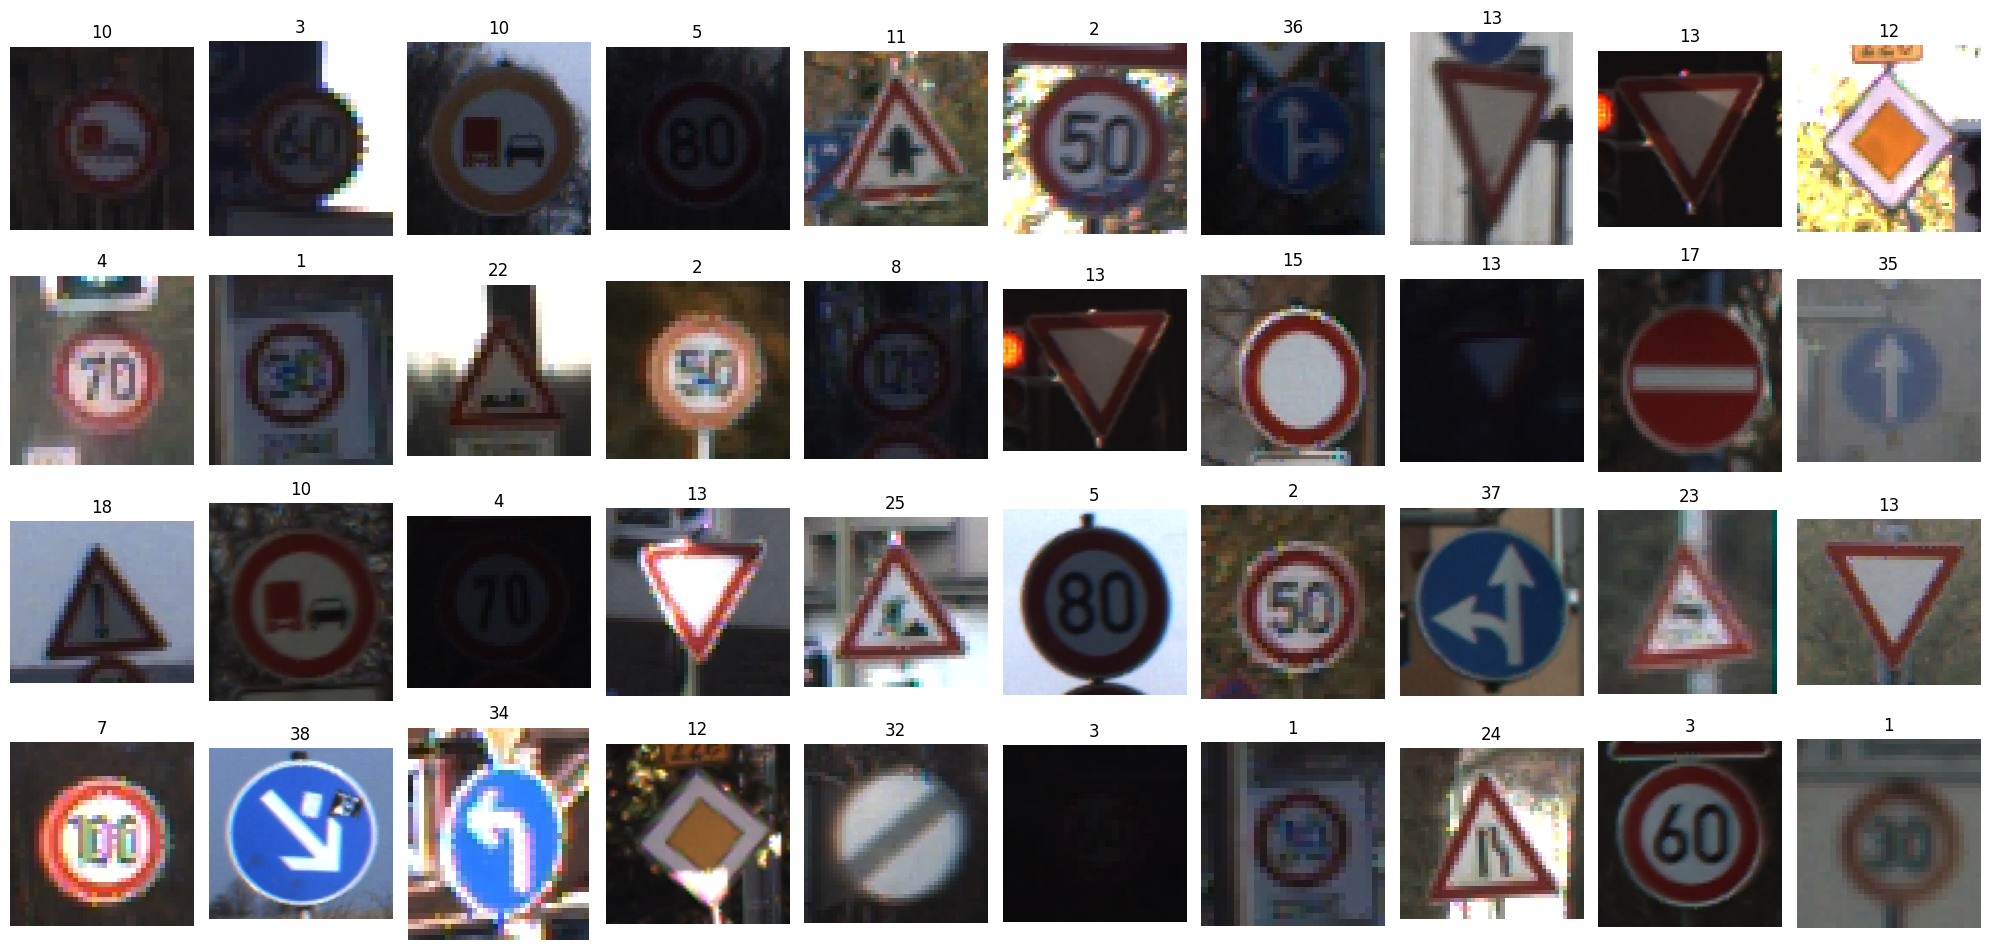

In [ ]:
fig, axes = plt.subplots(4, 10, figsize=(20,10))
balanced_images = df.values
np.random.shuffle(balanced_images)
balanced_images = pd.DataFrame(balanced_images)
for i in range(4):
    for j in range(10):
        image = imread(balanced_images.iloc[j + 10 * i][7])
        axes[i,j].imshow(image)
        axes[i, j].set_title(balanced_images.iloc[j + 10 * i][6])
        axes[i, j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])

## **5. Visualizing Class Distribution**

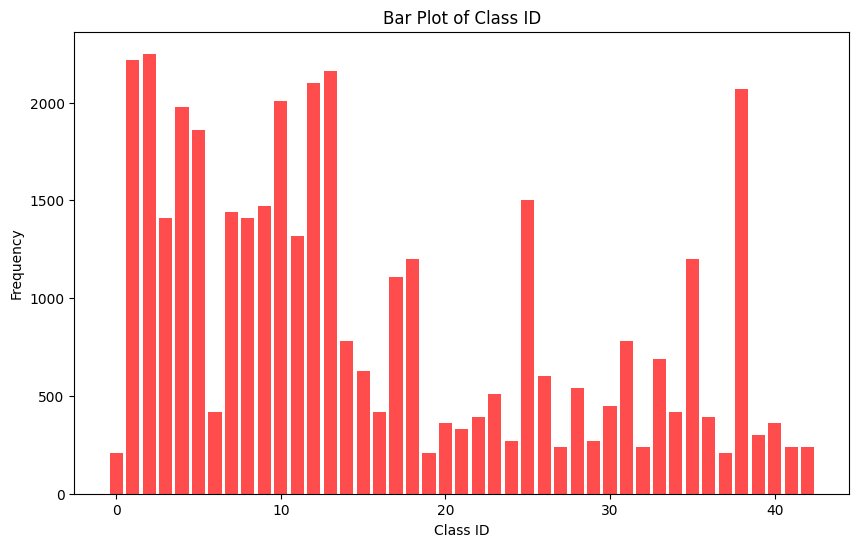

In [ ]:
plt.figure(figsize=(10, 6))
counts = df['ClassId'].value_counts()
plt.bar(counts.index, counts.values, color='red', alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Bar Plot of Class ID')
plt.show()

## **6. Data Preprocessing**

In [ ]:
# Preprocess training data
images = []
labels = []
for index, row in df.iterrows():
    image = Image.open(row["Path"])
    cropped_image = image.crop((row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']))
    image = cv2.imread(row["Path"], cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (50, 50), interpolation = cv2.INTER_LINEAR)
    images.append(np.array(image))
    labels.append(row['ClassId'])
X_train = np.array(images)
y_train = np.array(labels)

In [ ]:
# Preprocess test data
images = []
labels = []
for index, row in test_data.iterrows():
    image = Image.open(row["Path"])
    cropped_image = image.crop((row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']))
    image = cv2.imread(row["Path"], cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (50, 50), interpolation = cv2.INTER_LINEAR)
    images.append(np.array(image))
    labels.append(row['ClassId'])
X_test = np.array(images)
y_test = np.array(labels)

In [ ]:
# Convert the labels to categorical (one-hot encoded)
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

## **7. Building the CNN Model**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 391,339 (1.49 MB)

 Trainable params: 390,891 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

## **8. Training the Model**

In [ ]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64,
                    callbacks=[early_stopping, lr_reduction])

Epoch 1/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 315s 502ms/step - accuracy: 0.3242 - loss: 2.5668 - val_accuracy: 0.9123 - val_loss: 0.3438 - learning_rate: 0.0010
Epoch 2/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 319s 497ms/step - accuracy: 0.9168 - loss: 0.2558 - val_accuracy: 0.9573 - val_loss: 0.1774 - learning_rate: 0.0010
Epoch 3/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 319s 492ms/step - accuracy: 0.9672 - loss: 0.1016 - val_accuracy: 0.9626 - val_loss: 0.2041 - learning_rate: 0.0010
Epoch 4/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 324s 497ms/step - accuracy: 0.9796 - loss: 0.0602 - val_accuracy: 0.9631 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 5/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 321s 495ms/step - accuracy: 0.9856 - loss: 0.0479 - val_accuracy: 0.9669 - val_loss: 0.1620 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


## **9. Evaluating the Model**

In [ ]:
# accuracy and loss
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

395/395 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9670 - loss: 0.1551
Test Accuracy: 0.9669042229652405
Loss: 0.16203241050243378


In [ ]:
# Classification Report
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

395/395 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        60
           1       0.96      1.00      0.98       720
           2       0.98      0.98      0.98       750
           3       0.96      0.96      0.96       450
           4       0.99      0.97      0.98       660
           5       0.95      0.98      0.97       630
           6       0.99      0.93      0.96       150
           7       0.99      0.95      0.97       450
           8       0.96      0.97      0.96       450
           9       0.96      1.00      0.98       480
          10       1.00      0.99      0.99       660
          11       0.98      0.98      0.98       420
          12       0.96      1.00      0.98       690
          13       0.99      0.99      0.99       720
          14       1.00      0.99      0.99       270
          15       1.00      0.99      0.99       210
          16       0.97      1.00     

## **10. Confusion Matrix**

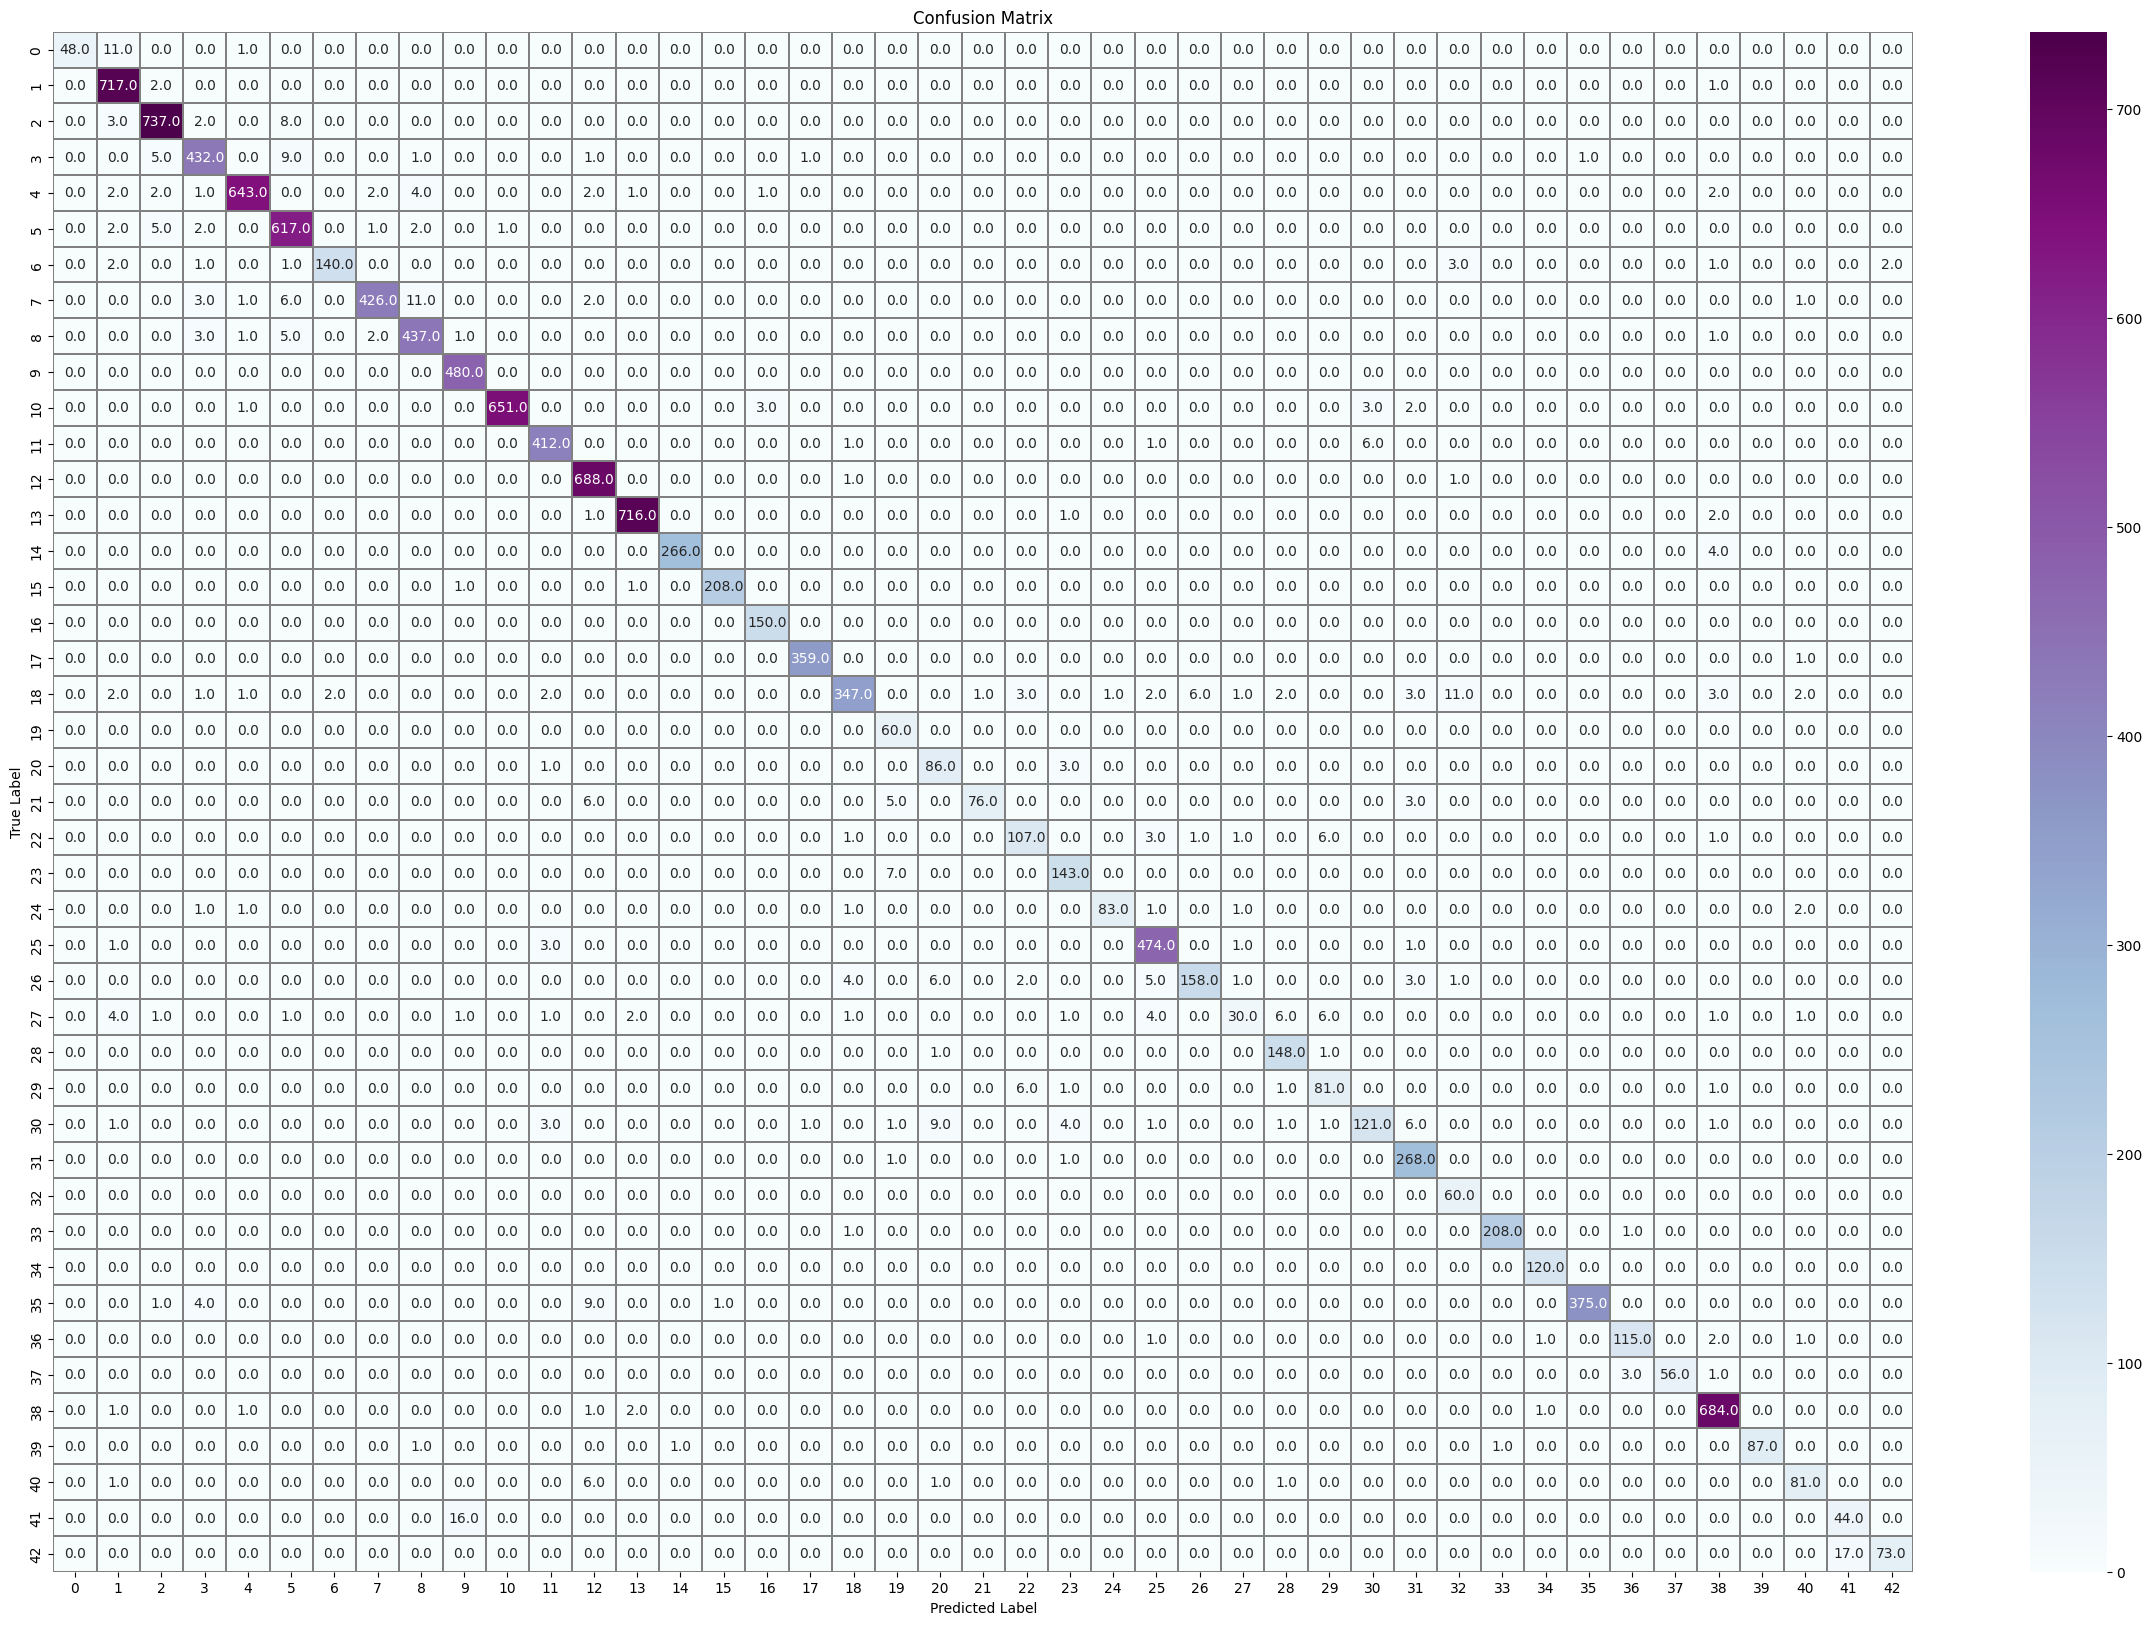

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## **11. Training History**

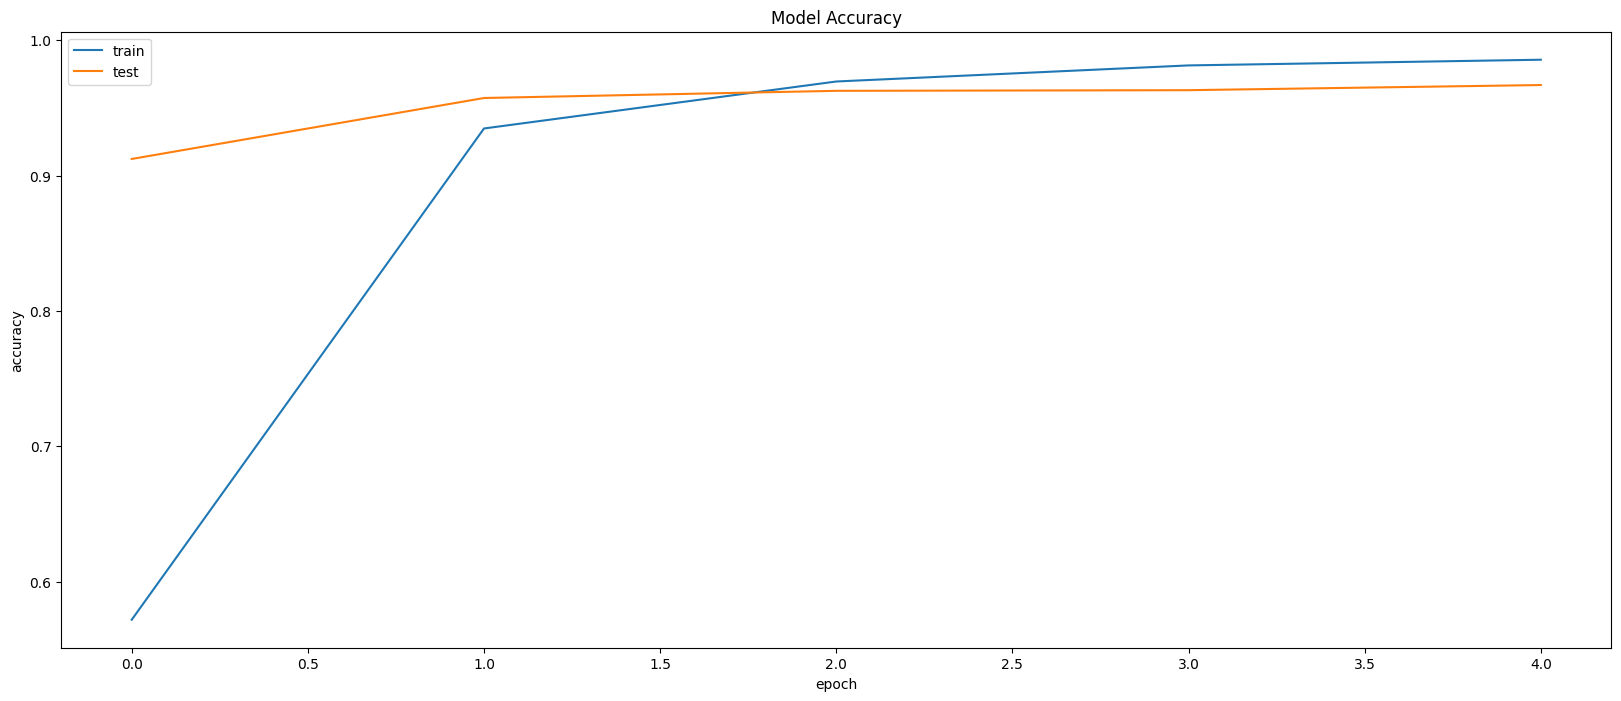

In [ ]:
# Plot accuracy
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

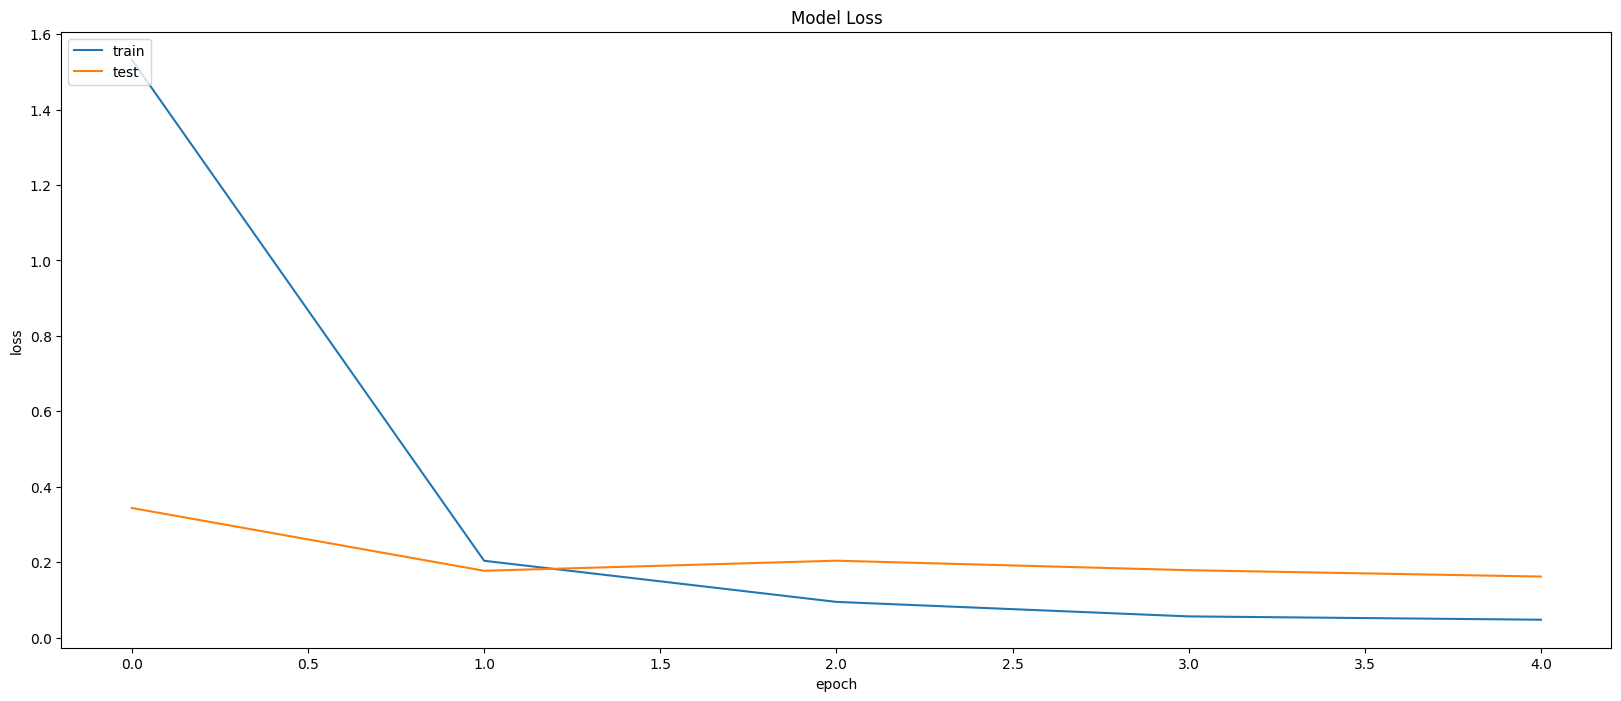

In [ ]:
# Plot loss
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

class_labels = sorted(df['ClassId'].unique())

class_label_meanings = {
     0: "Speed limit (20km/h)",
     1: "Speed limit (30km/h)",
     2: "Speed limit (50km/h)",
     3: "Speed limit (60km/h)",
     4: "Speed limit (70km/h)",
     5: "Speed limit (80km/h)",
     6: "End of Speed limit (80km/h)",
     7: "Speed limit (100km/h)",
     8: "Speed limit (120km/h)",
     9: "NO OVERTAKING",
     10: "NO OVERTAKING FOR A POWER DRIVEN VEHICLES FOR PERMISSIBLE TOTAL WEIGHT OF 3.5T",
     11: "Priority at next Intersection",
     12: "Priority Road",
     13: "Give way",
     14: "STOP",
     15: "NO VEHICLES",
     16: "NO power driven vehicle permissible for a vehicle of total weight 3.5T",
     17: "NO ENTRY",
     18: "DANGER/CAUTION",
     19: "LEFT BEND",
     20: "RIGHT BEND",
     21: "DOUBLE BEND LEFT TO RIGHT ",
     22: "UNEVEN ROAD",
     23: "ROAD SLIPPERY WHEN WET",
     24: "ROAD NARROWS",
     25: "ROAD WORKS",
     26: "TRAFFIC LIGHT SIGNALS",
     27: "PEDESTRIANS",
     28: "CHILDREN",
     29: "BICYCLE",
     30: "ICE/SNOW",
     31: "WILD ANIMAL CROSSING",
     32: "END OF ALL PREVIOUS PROHIBITIONS OR RESTRICTIONS",
     33: "TURN RIGHT AHEAD",
     34: "LEFT TURN AHEAD",
     35: "AHEAD ONLY",
     36: "AHEAD OR RIGHT ONLY",
     37: "AHEAD OR ;LEFT ONLY",
     38: "PASS ON THE RIGHT",
     39: "PASS ON THE LEFT",
     40: "ROUNDABOUT",
     41: "END OF PROHIBITION TO OVERTAKE ON POWER DRIVEN VEHICLES",
     42: "END OF PROHIBITION TO OVERTAKE ON POWER DRIVEN VEHICLES OVER 3.5T"
 }

for i, label in enumerate(class_labels):
   print(f"Class Label: {label}, Encoded Number: {i}, Meaning: {class_label_meanings.get(label, 'Unknown')}")

Class Label: 0, Encoded Number: 0, Meaning: Speed limit (20km/h)
Class Label: 1, Encoded Number: 1, Meaning: Speed limit (30km/h)
Class Label: 2, Encoded Number: 2, Meaning: Speed limit (50km/h)
Class Label: 3, Encoded Number: 3, Meaning: Speed limit (60km/h)
Class Label: 4, Encoded Number: 4, Meaning: Speed limit (70km/h)
Class Label: 5, Encoded Number: 5, Meaning: Speed limit (80km/h)
Class Label: 6, Encoded Number: 6, Meaning: End of Speed limit (80km/h)
Class Label: 7, Encoded Number: 7, Meaning: Speed limit (100km/h)
Class Label: 8, Encoded Number: 8, Meaning: Speed limit (120km/h)
Class Label: 9, Encoded Number: 9, Meaning: NO OVERTAKING
Class Label: 10, Encoded Number: 10, Meaning: NO OVERTAKING FOR A POWER DRIVEN VEHICLES FOR PERMISSIBLE TOTAL WEIGHT OF 3.5T
Class Label: 11, Encoded Number: 11, Meaning: Priority at next Intersection
Class Label: 12, Encoded Number: 12, Meaning: Priority Road
Class Label: 13, Encoded Number: 13, Meaning: Give way
Class Label: 14, Encoded Number:

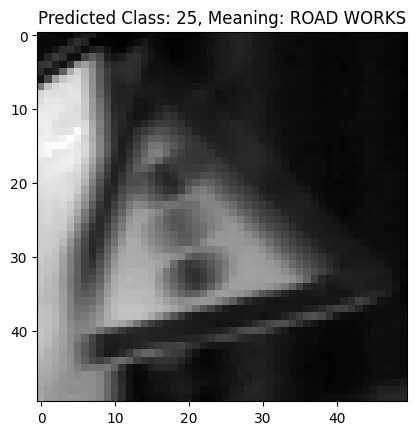

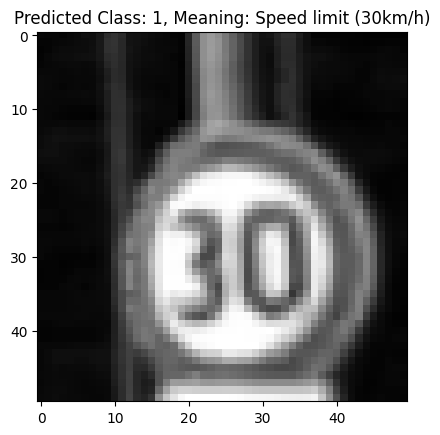

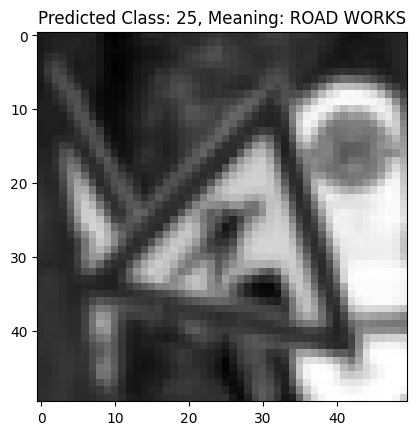

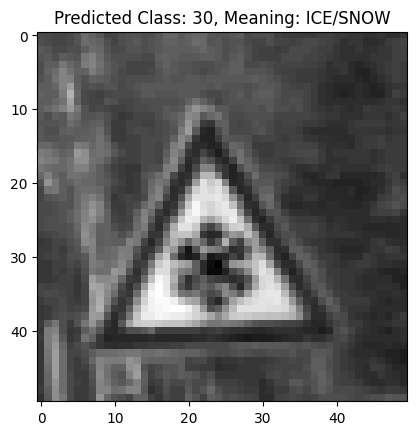

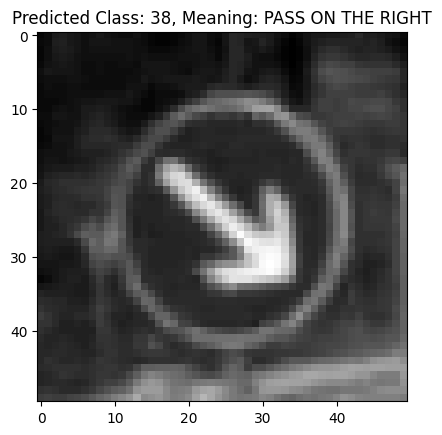

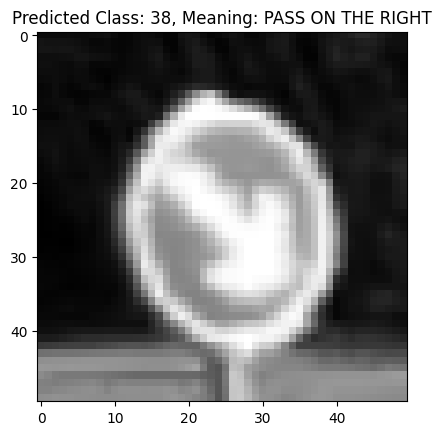

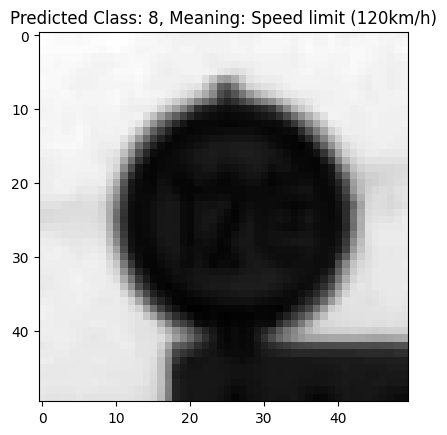

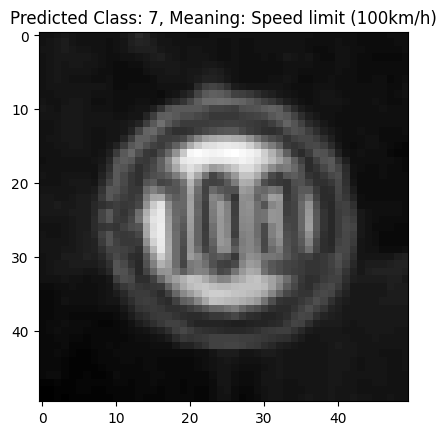

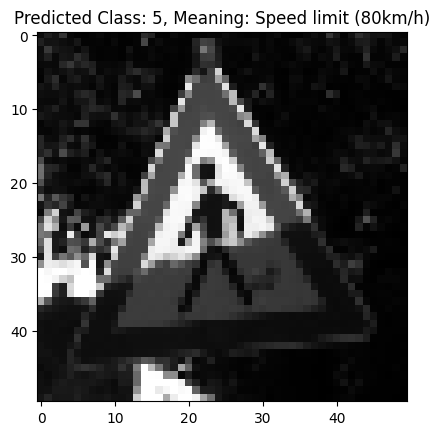

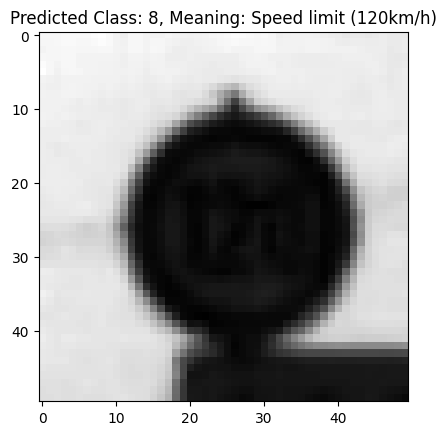

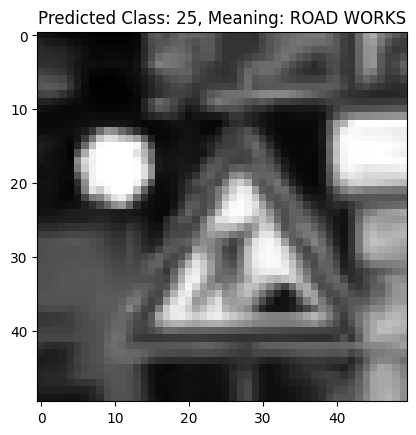

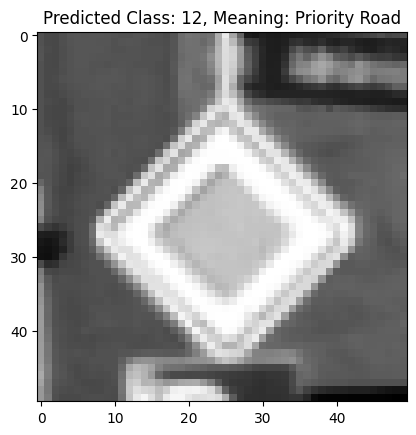

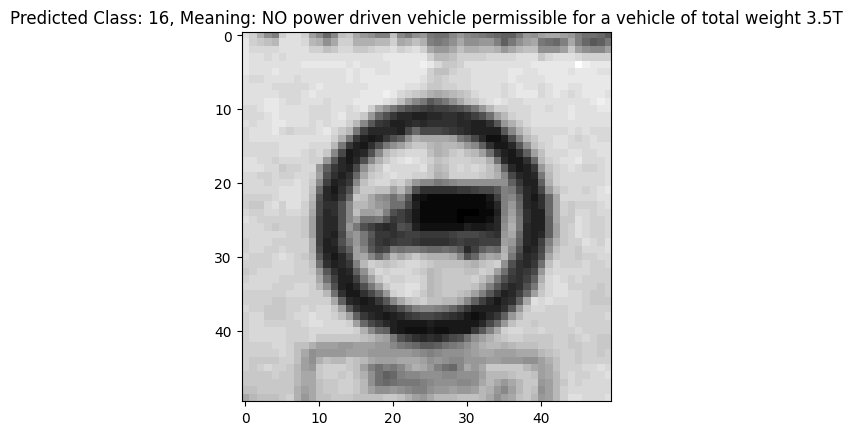

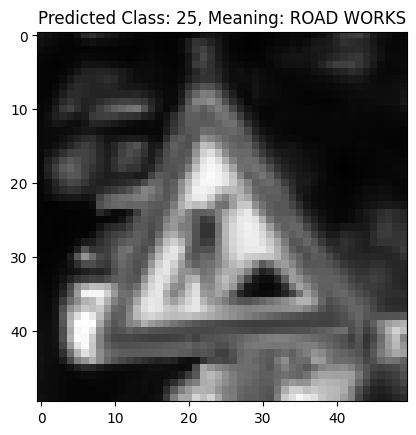

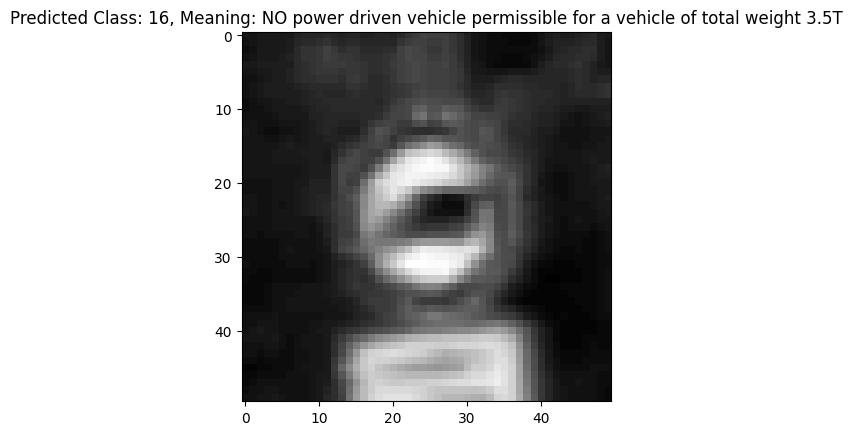

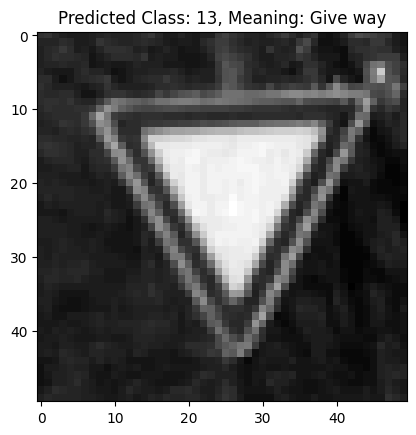

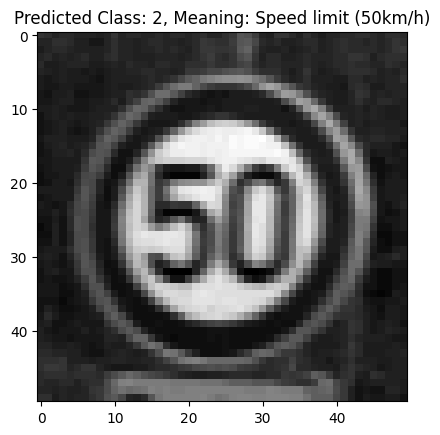

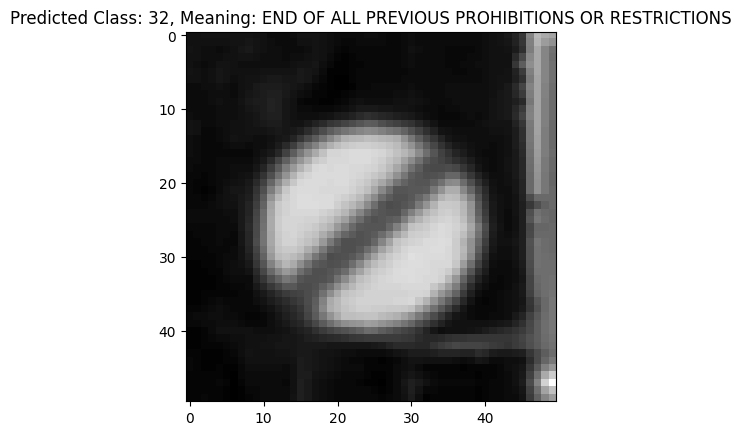

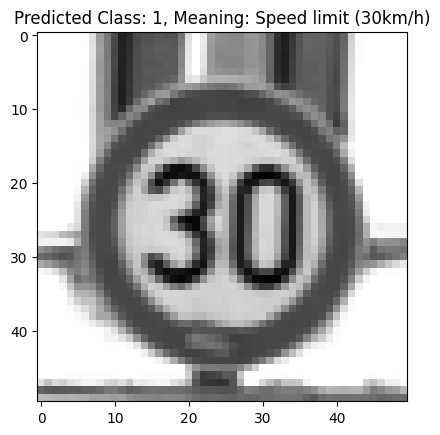

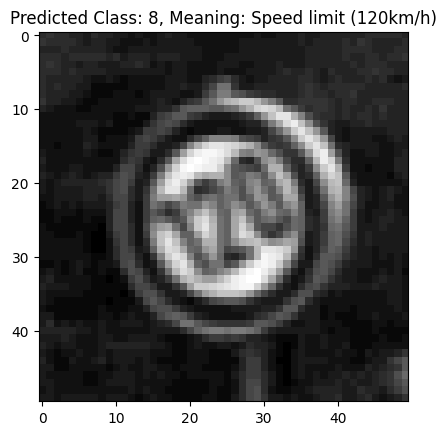

In [ ]:

import random

num_images_to_show = 20
random_indices = random.sample(range(len(X_test)), num_images_to_show)

for index in random_indices:
    image = X_test[index]
    predicted_class = y_pred_classes[index]
    predicted_class_meaning = class_label_meanings.get(predicted_class, "Unknown")
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Class: {predicted_class}, Meaning: {predicted_class_meaning}")
    plt.show()

In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score



# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Create a table for the final results
results_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, precision, recall, f1]
})

print("Evaluation Results:")
print(results_table)

# ... (Rest of your code) ...